## Detecting Twitter Bots


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
mpl.rcParams['patch.force_edgecolor'] = True
warnings.filterwarnings("ignore")

%matplotlib inline


### Data analysis

#### Identify Missing Data

In [2]:
#loading the data
filepath = r'..\DataSet'
originalData = filepath + r'\bot_detection_data.csv'
#reading the data set
df = pd.read_csv(originalData)

In [3]:
def get_heatmap(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    plt.show()

Missing values in the data set:


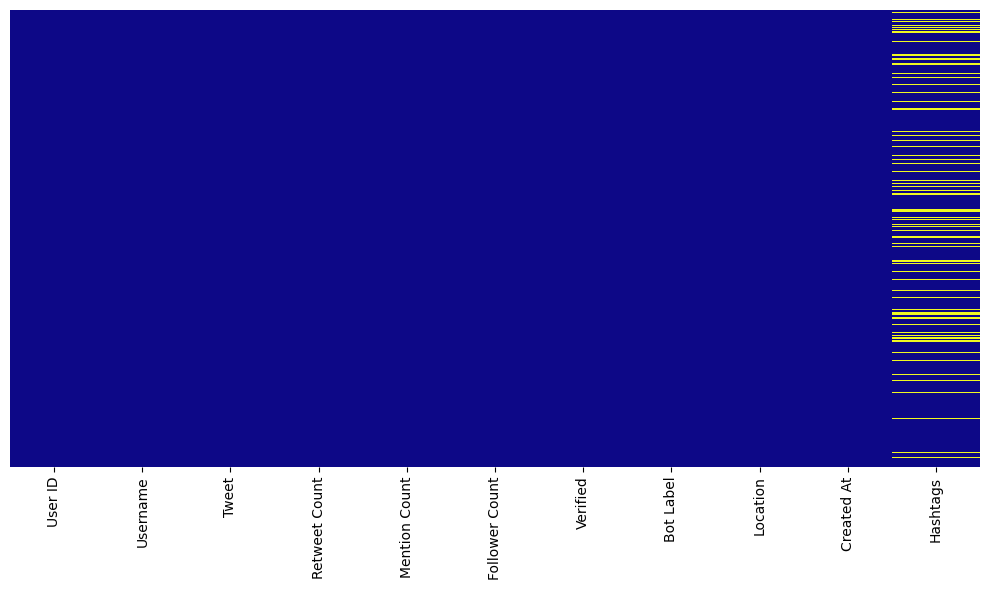

In [4]:
# Identify missing data in the data set
bots = df[df['Bot Label'] == 1]
nonbots = df[df['Bot Label'] == 0]

print("Missing values in the data set:")
get_heatmap(df)

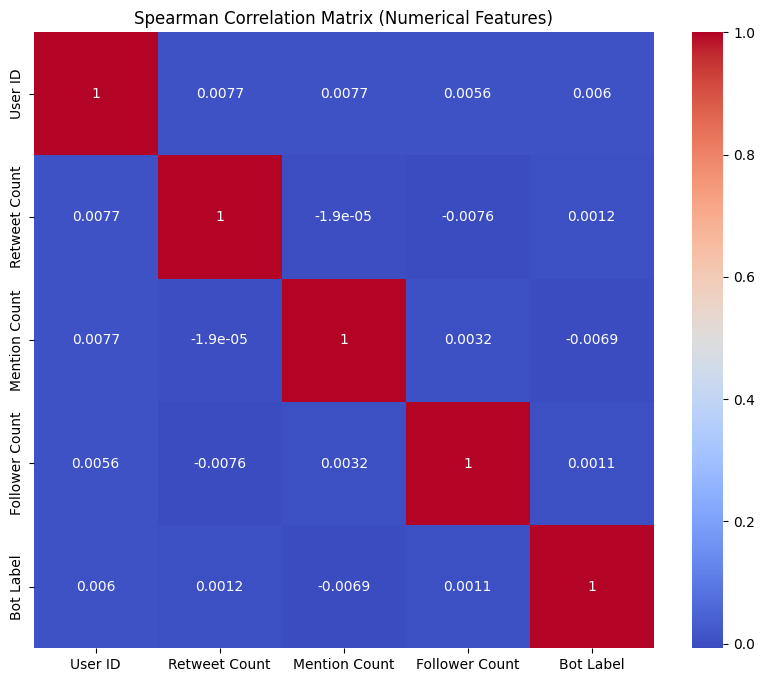

In [5]:
# Separate numerical and non-numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns

# Compute Spearman's correlation for numerical columns
numeric_data = df[numeric_cols]
corr = numeric_data.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix (Numerical Features)')
plt.show()

#### Interpreting the matrix

In this Spearman's correlation matrix, we can observe that the numerical features in the dataset are not strongly correlated with each other.

### Analysing Follower counts, Usernames, Locattion, and Verification Status 

Follower Count Distribution


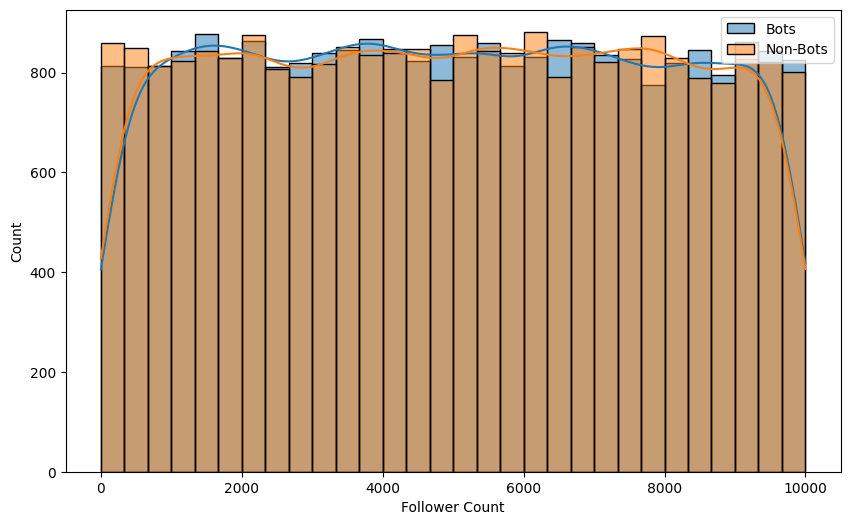

Username Contains 'bot'
    - Bots: 12 out of 25018
    - Non-Bots: 6 out of 24982
Location Missing
    -Bots: 0 out of 25018
    -Non-Bots: 0 out of 24982
Verified
    - Bots: 12478 out of 25018
    - Non-Bots: 12526 out of 24982


In [6]:
# Analyze Follower Count
print("Follower Count Distribution")
plt.figure(figsize=(10, 6))
sns.histplot(bots['Follower Count'], label='Bots', kde=True)
sns.histplot(nonbots['Follower Count'], label='Non-Bots', kde=True)
plt.legend()
plt.show()

# Analyze Username
print("Username Contains 'bot'")
print(f"    - Bots: {bots['Username'].str.contains('bot', case=False).sum()} out of {len(bots)}")
print(f"    - Non-Bots: {nonbots['Username'].str.contains('bot', case=False).sum()} out of {len(nonbots)}")

# Analyze Location
print("Location Missing")
print(f"    -Bots: {bots['Location'].isnull().sum()} out of {len(bots)}")
print(f"    -Non-Bots: {nonbots['Location'].isnull().sum()} out of {len(nonbots)}")

# Analyze Verified
print("Verified")
print(f"    - Bots: {bots['Verified'].sum()} out of {len(bots)}")
print(f"    - Non-Bots: {nonbots['Verified'].sum()} out of {len(nonbots)}")

### Visualising the Data for Usename, Location, and Verified

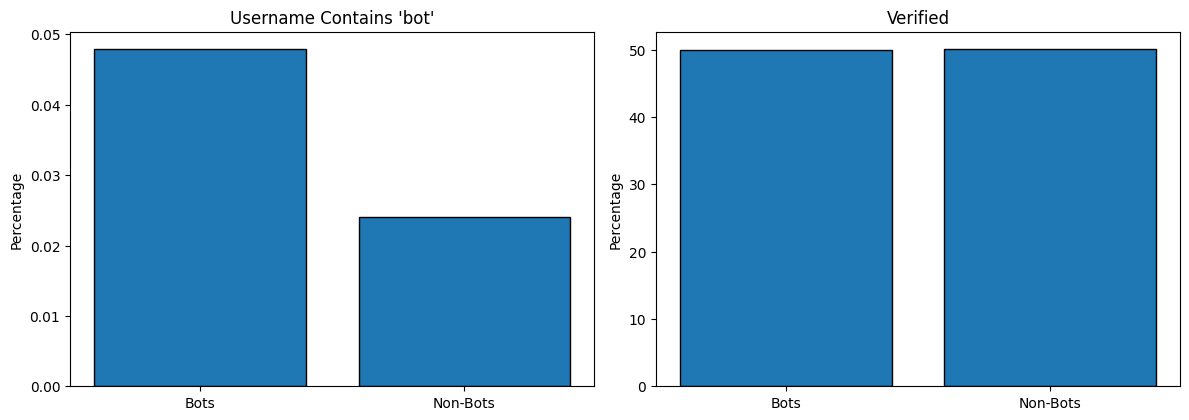

In [7]:
# Create a new figure for bar plots
plt.figure(figsize=(12, 8))

# Plot Username Contains 'bot'
plt.subplot(2, 2, 1)
total_bots = len(bots)
total_nonbots = len(nonbots)
bot_username_percentage = (bots['Username'].str.contains('bot', case=False).sum() / total_bots) * 100
nonbot_username_percentage = (nonbots['Username'].str.contains('bot', case=False).sum() / total_nonbots) * 100
plt.bar(['Bots', 'Non-Bots'], [bot_username_percentage, nonbot_username_percentage])
plt.title("Username Contains 'bot'")
plt.ylabel("Percentage")

# Plot Verified
plt.subplot(2, 2, 2)
bot_verified_percentage = (bots['Verified'].sum() / total_bots) * 100
nonbot_verified_percentage = (nonbots['Verified'].sum() / total_nonbots) * 100
plt.bar(['Bots', 'Non-Bots'], [bot_verified_percentage, nonbot_verified_percentage])
plt.title("Verified")
plt.ylabel("Percentage")

plt.tight_layout()
plt.show()

#### Interpreting the data

based on the data we see that the every account in the training data set has a location so it can't be used to snuff out bots. Another interesting detail is that most bots do not have 'bot' in their displayed username. However, some non-bots account has 'bot' in their displayed name, meaning we can't rely on usernames to identify bots either. Finally, the verified badge that was the corner stone of identifying bots is now not reliable thanks to X introducing the ability to subscribed to twitter for verification. 

#### Performing Feature Engineering

In [8]:
bag_of_words_bot = r'human|education|store|skin|pressure|resource|culture|world||spend|far|sport|adult|work|give|beat|concern'\
    r'|edge|protect|religious|cultural|nation|new|technology|rate|policy|page|challenge|citizen|reflect|behavior|together|partner|computer'\
    r'|purpose|local|forget|marriage|environment|house|million|project|consumer|win|society|social|threat|hard|experience|help'\
    r'|claim|free|college|game|early|executive|medical|tax|attack||president|administration|situation|conference|benefit|safe|'\
    r'|trade|budget|significant|sell|represent|available|professor|industry|government|knowledge|notice|real|natural'\
    r'|identify|increase|result|design|theory|politics|generation|employee|drug|congress|discussion|police|machine|cost'\
    r'|operation|country|ability|range|art|truth|task|individual|recognize'\

# Create binary features for username and tweet
df['username_binary'] = df['Username'].str.contains(bag_of_words_bot, case=False, na=False)
df['tweet_binary'] = df['Tweet'].str.contains(bag_of_words_bot, case=False, na=False)

df['Hashtags'].fillna('', inplace=True)
df['hashtag_binary'] = df['Hashtags'].str.contains(bag_of_words_bot, case=False, na=False)

#### Performing Feature Extraction

Engagement Ratio:
- The engagement ratio can be calculated as the ratio of retweets to followers.

Hashtag Count:
- Count the number of hashtags in each tweet. Some tweets have no hashtags as shown on the heat map

In [9]:
df['engagement_ratio'] = np.where(df['Follower Count'] == 0, df['Retweet Count'], df['Retweet Count'] / df['Follower Count'])

df['hashtag_count'] = df['Hashtags'].apply(lambda x: 0 if pd.isna(x) else len(x.split()))

## Implementing Different Models

### Decision Tree Classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

In [11]:
X = df[['username_binary', 'tweet_binary','hashtag_binary','engagement_ratio', 'hashtag_count', 'Mention Count', 'Verified']]
y = df['Bot Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10, random_state=42)
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.6f}")
print(f"Testing Accuracy: {test_accuracy:.6f}")

Training Accuracy: 0.590400
Testing Accuracy: 0.505800


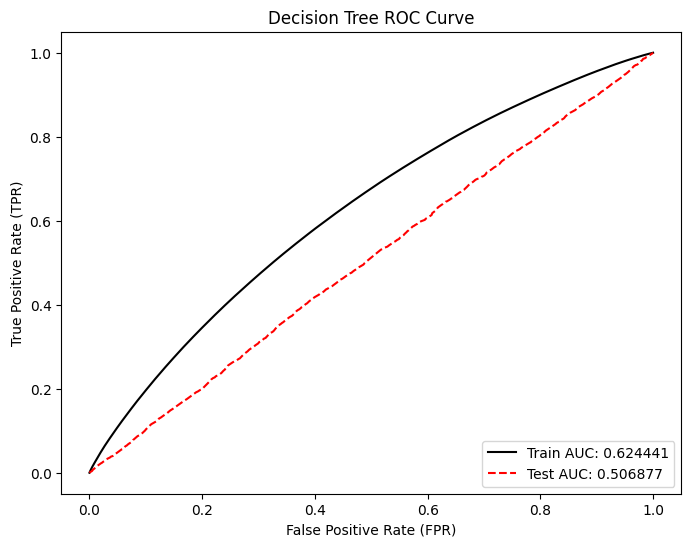

In [13]:
scores_train = clf.predict_proba(X_train)[:, 1]
scores_test = clf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, scores_train, pos_label=1)
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test, pos_label=1)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='black', label=f'Train AUC: {auc_train:.6f}')
plt.plot(fpr_test, tpr_test, color='red', ls='--', label=f'Test AUC: {auc_test:.6f}')
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.show()


### Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

# Accuracy on data
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.5f}")
print(f"Testing Accuracy: {test_accuracy:.5f}")

Training Accuracy: 0.65957
Testing Accuracy: 0.50193


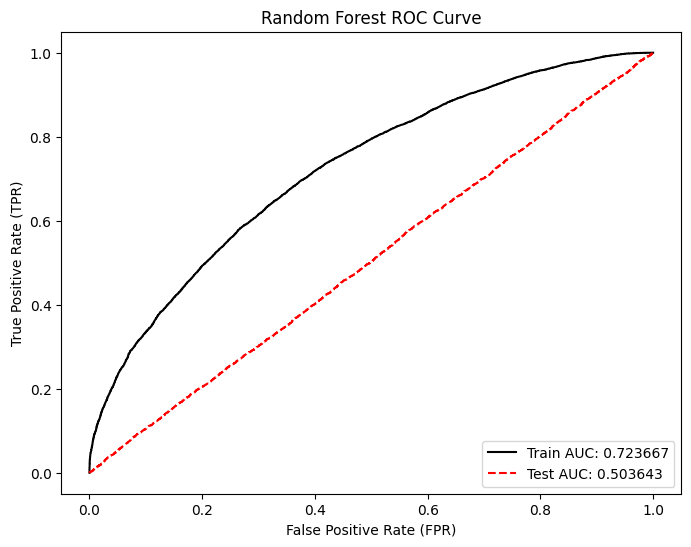

In [16]:
scores_train = clf.predict_proba(X_train)[:, 1]
scores_test = clf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, scores_train, pos_label=1)
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test, pos_label=1)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='black', label=f'Train AUC: {auc_train:.6f}')
plt.plot(fpr_test, tpr_test, color='red', ls='--', label=f'Test AUC: {auc_test:.6f}')
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.show()

### Gradient Boosting XGBoost


In [17]:
from xgboost import XGBClassifier

In [18]:
# Create and train the XGBoost Classifier
clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.54
Testing Accuracy: 0.50


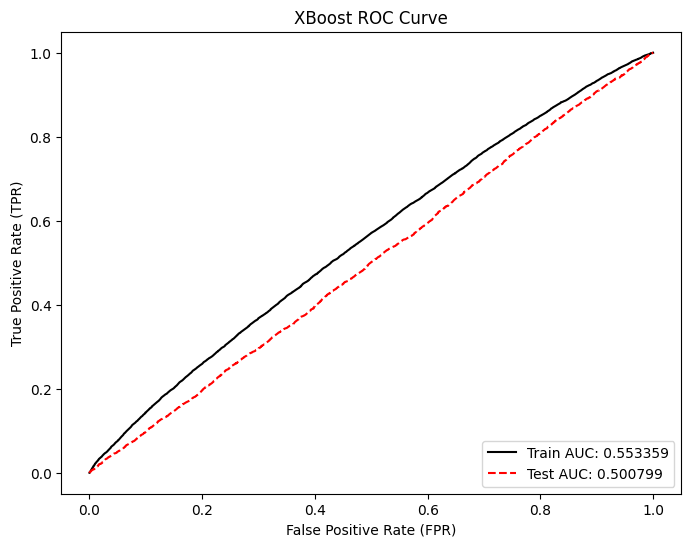

In [19]:
scores_train = clf.predict_proba(X_train)[:, 1]
scores_test = clf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, scores_train, pos_label=1)
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test, pos_label=1)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='black', label=f'Train AUC: {auc_train:.6f}')
plt.plot(fpr_test, tpr_test, color='red', ls='--', label=f'Test AUC: {auc_test:.6f}')
plt.title("XBoost ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.show()